In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 2.2MB/s 
     |████████████████████████████████| 3.3MB 23.5MB/s 
     |████████████████████████████████| 901kB 31.5MB/s 


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("/content/drive/MyDrive/Project 1/train_official_ver2.csv", 
                   encoding="utf-8").fillna(method="ffill")

In [ ]:
data.head(20)

,Word,Tag,Sentence #
0,xe,B-TYPE,Sentence: 1
1,lăn,I-TYPE,Sentence: 1
2,dùng,O,Sentence: 1
3,cho,O,Sentence: 1
4,bệnh,O,Sentence: 1
5,nhân,O,Sentence: 1
6,",",O,Sentence: 1
7,người,O,Sentence: 1
8,tàn,O,Sentence: 1
9,tật,O,Sentence: 1


In [ ]:
data["Word"] = data.Word.apply(str)

In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [ ]:
getter = SentenceGetter(data)


In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]


['xe',
 'lăn',
 'dùng',
 'cho',
 'bệnh',
 'nhân',
 ',',
 'người',
 'tàn',
 'tật',
 'h011q',
 '16',
 "''",
 'blue',
 '.',
 'mới',
 '100',
 '%']

In [ ]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])


['B-TYPE', 'I-TYPE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'O', 'O', 'O', 'O', 'B-STATUS', 'I-STATUS', 'I-STATUS']


In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
#luu lai tudien
import pickle
tag_values_file = open("/content/drive/MyDrive/Project 1/tag_values.pkl", "wb")
pickle.dump(tag_values, tag_values_file)
tag_values_file.close()

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.8.1+cu101'

In [ ]:
MAX_LEN = 75
bs = 32


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()


In [ ]:
#conda install -c pytorch pytorch=1.2.0=py3.7_cuda92_cudnn7_1

In [ ]:
#conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

In [ ]:
torch.cuda.get_device_name(0)


'Tesla P4'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [ ]:
tokenized_texts_and_labels[0][1]

['B-TYPE',
 'B-TYPE',
 'I-TYPE',
 'I-TYPE',
 'I-TYPE',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-NAME',
 'B-NAME',
 'B-NAME',
 'B-NAME',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-STATUS',
 'B-STATUS',
 'B-STATUS',
 'I-STATUS',
 'I-STATUS']

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [ ]:
len(labels[0])

41

In [ ]:
len(tokenized_texts[0])

41

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.6.1'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.cuda();


In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 1.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=54755e6373eb92f060e393f4259a2cec186a5d702f96711a58d9cee131f1e70d
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score


In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [[tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]]
    valid_tags = [[tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Average train loss: 0.1782722521010997
Validation loss: 0.030144945190598568
Validation Accuracy: 0.9913310821027166


Epoch:  20%|██        | 1/5 [02:11<08:47, 131.91s/it]

Validation F1-Score: 0.974222633221593

Average train loss: 0.025445445749978975
Validation loss: 0.020477564648414652
Validation Accuracy: 0.9944559246005745


Epoch:  40%|████      | 2/5 [04:27<06:38, 132.89s/it]

Validation F1-Score: 0.9846859764840837

Average train loss: 0.013627506528963457
Validation loss: 0.01996472478689005
Validation Accuracy: 0.9953463367101792


Epoch:  60%|██████    | 3/5 [06:42<04:27, 133.60s/it]

Validation F1-Score: 0.9873751865029267

Average train loss: 0.00855283278462319
Validation loss: 0.015554571248746167
Validation Accuracy: 0.9962031483628178


Epoch:  80%|████████  | 4/5 [08:57<02:14, 134.11s/it]

Validation F1-Score: 0.9891717544061743

Average train loss: 0.0058333208834980875
Validation loss: 0.016257053959998304
Validation Accuracy: 0.9962703492767502


Epoch: 100%|██████████| 5/5 [11:12<00:00, 134.57s/it]

Validation F1-Score: 0.9890210955911939



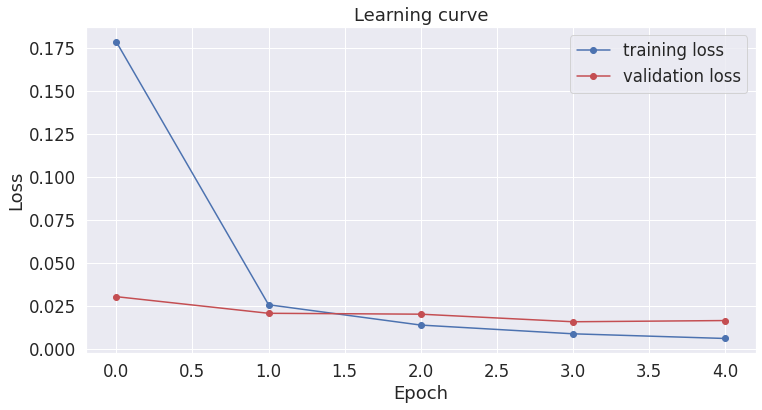

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
test_sentence = "xe ô tô mercedes benz sản xuất năm 1956 sử dụng xăng , đã qua sử dụng"
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
        
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

B-TYPE	[CLS]
B-TYPE	xe
I-TYPE	ô
I-TYPE	tô
B-BRAND	mercedes
I-BRAND	benz
O	sản
O	xuất
O	năm
B-YEAR	1956
O	sử
O	dụng
B-ENGINE_FULE_TYPE	xăng
O	,
B-STATUS	đã
I-STATUS	qua
I-STATUS	sử
I-STATUS	dụng
O	[SEP]


In [ ]:
def predict(test_sentence):
    tokenized_sentence = tokenizer.encode(test_sentence)
    input_ids = torch.tensor([tokenized_sentence]).cuda()

    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    # join bpe split tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    return new_labels[1:-1]

In [ ]:
data_test = pd.read_csv("/content/drive/MyDrive/Project 1/test_official_ver2.csv",
                        encoding="utf-8")
data_test.head(20)
data_test["Word"] = data_test.Word.apply(str)

In [ ]:
getter_test = SentenceGetter(data_test)

In [ ]:
sentences_test = [[word[0] for word in sentence] for sentence in getter_test.sentences]
sentences_test[0]

['xe',
 'có',
 'bô',
 'cho',
 'người',
 'khuyết',
 'tật',
 'gk-96',
 '.',
 'hiệu',
 'lucass',
 ',',
 'hàng',
 'mới',
 '100',
 '%']

In [ ]:
labels_test = [[s[1] for s in sentence] for sentence in getter_test.sentences]
print(labels_test[0])

['B-TYPE', 'I-TYPE', 'I-TYPE', 'O', 'O', 'O', 'O', 'B-NAME', 'O', 'O', 'B-BRAND', 'O', 'O', 'B-STATUS', 'I-STATUS', 'I-STATUS']


In [ ]:
A, B = [], []
for sent, labs in zip(sentences_test, labels_test):
    c, d = tokenize_and_preserve_labels(sent, labs)
    A.append(c)
    B.append(d)

In [ ]:
new_tokens, new_labels = [], []
for token, label_idx in zip(A[0], B[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(label_idx)
        new_tokens.append(token)

In [ ]:
M, N = [], []
for i in range(len(A)):
    new_tokens, new_labels = [], []
    for token, label_idx in zip(A[i], B[i]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(label_idx)
            new_tokens.append(token)
    M.append(new_tokens)
    N.append(new_labels)

In [ ]:
X = []
for i in sentences_test:
    X.append(' '.join(i))
X[0]

'xe có bô cho người khuyết tật gk-96 . hiệu lucass , hàng mới 100 %'

In [ ]:
y_pred = []
for i in X:
  y_pred.append(predict(i))
y_pred[0]

['O',
 'O',
 'I-TYPE',
 'O',
 'O',
 'O',
 'O',
 'B-NAME',
 'B-NAME',
 'B-NAME',
 'O',
 'O',
 'B-BRAND',
 'O',
 'O',
 'B-STATUS',
 'I-STATUS',
 'I-STATUS']

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
mlb = MultiLabelBinarizer()

In [ ]:
tag_values.remove("PAD")

In [ ]:
tag_values

['B-ENGINE_FULE_TYPE',
 'I-BRAND',
 'I-STATUS',
 'I-TYPE',
 'B-TYPE',
 'O',
 'B-BRAND',
 'I-NAME',
 'B-YEAR',
 'B-NAME',
 'B-STATUS']

In [ ]:
mlb.fit([tag_values])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [ ]:
mlb.classes_

array(['B-BRAND', 'B-ENGINE_FULE_TYPE', 'B-NAME', 'B-STATUS', 'B-TYPE',
       'B-YEAR', 'I-BRAND', 'I-NAME', 'I-STATUS', 'I-TYPE', 'O'],
      dtype=object)

In [ ]:
actual = mlb.transform(N)

In [ ]:
pred = mlb.transform(y_pred)

In [ ]:
print(classification_report(actual,pred, target_names=mlb.classes_))

                    precision    recall  f1-score   support

           B-BRAND       1.00      0.98      0.99      1707
B-ENGINE_FULE_TYPE       0.98      0.99      0.98       864
            B-NAME       0.97      0.98      0.97      1188
          B-STATUS       1.00      0.99      0.99      1899
            B-TYPE       1.00      0.95      0.97      1611
            B-YEAR       0.96      1.00      0.98      1174
           I-BRAND       0.99      0.95      0.97       153
            I-NAME       0.99      0.99      0.99       470
          I-STATUS       0.99      0.99      0.99      1816
            I-TYPE       1.00      0.96      0.98      2137
                 O       1.00      1.00      1.00      2341

         micro avg       0.99      0.98      0.99     15360
         macro avg       0.99      0.98      0.98     15360
      weighted avg       0.99      0.98      0.99     15360
       samples avg       0.99      0.98      0.98     15360



In [ ]:
torch.save(model, "/content/drive/MyDrive/Project 1/model_ver2.pt")